In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix, plot_roc_curve, roc_auc_score

# Data Prep

In [3]:
#Read in data

data_dir = '/Users/gregyannett/Documents/nba_game_models/data/datasets/'

gamelogs = pd.read_csv(data_dir + 'all_games.csv')
spreads = pd.read_csv(data_dir + 'all_spreads.csv')
moneylines = pd.read_csv(data_dir + 'all_moneylines.csv')

In [4]:
#add result of game
gamelogs['win'] = np.where(gamelogs['pt_diff'] > 0, 1, 0)


suffix_list = ['roll_1', 'roll_2', 'roll_3', 'roll_4', 'roll_5', 'roll_6', 'roll_7', 'roll_8', 'roll_9', 'roll_10',
               'exp_0.0001', 'exp_0.001', 'exp_0.005', 'exp_0.01', 'exp_0.05', 'exp_0.1', 'exp_0.2', 'exp_0.3', 'exp_0.5', 'exp_0.75', 'exp_0.9', 'exp_0.95']

#add net rating (ortg - drtg)
for suff in suffix_list:
    gamelogs['nrtg_' + suff] = gamelogs['ortg_' + suff] - gamelogs['drtg_' + suff]
    gamelogs['away_nrtg_' + suff] = gamelogs['away_ortg_' + suff] - gamelogs['away_drtg_' + suff]


In [5]:
data = gamelogs.merge(spreads.drop(['date','home_team','away_team'],axis=1), on='id', how='left')
data = data.merge(moneylines.drop(['date','home_team','away_team'], axis=1), on='id', how='left')

In [6]:
betting_gamelogs = data[data['season'] >= 2007]

#drop all rows where all betting data is NaN
betting_gamelogs = betting_gamelogs[~betting_gamelogs.iloc[:, 1171:].isna().all(1)]

In [7]:
#Add the results ATS (for each book and for the average spread)

books = ['pinnacle', '5dimes', 'bookmaker', 'betonline', 'bovada', 'heritage', 'intertops', 'youwager', 'justbet']

for book in books:
    betting_gamelogs['result_ATS_'+book] = np.where(betting_gamelogs['home_'+book+'_spread'] + betting_gamelogs['pt_diff'] > 0, 1, 0)
    betting_gamelogs['result_ATS_'+book] = np.where(betting_gamelogs['home_'+book+'_spread'] + betting_gamelogs['pt_diff'] == 0, -1, betting_gamelogs['result_ATS_'+book])

betting_gamelogs['result_ATS_avg'] = np.where(betting_gamelogs['average_home_spread'] + betting_gamelogs['pt_diff'] > 0, 1, 0)
betting_gamelogs['result_ATS_avg'] = np.where(betting_gamelogs['average_home_spread'] + betting_gamelogs['pt_diff'] == 0, -1, betting_gamelogs['result_ATS_avg'])

In [8]:
# Add favorite for spread bets


home_fav = np.where((betting_gamelogs['average_home_odds'] < betting_gamelogs['average_away_odds']), 1, 0)
away_fav = np.where((betting_gamelogs['average_home_odds'] > betting_gamelogs['average_away_odds']), 2, 0)
no_fav = np.where((betting_gamelogs['average_home_odds'] == betting_gamelogs['average_away_odds']), 3, 0)

betting_gamelogs['spread_favorite'] = (home_fav + away_fav + no_fav)

# 0 for no odds, 1 for home favorite, 2 for away favorite, 3 for equal odds

In [9]:
#Drop games that push according to average spread
betting_gamelogs = betting_gamelogs[betting_gamelogs['result_ATS_avg'] >= 0]

betting_gamelogs = betting_gamelogs.reset_index(drop=True)

In [10]:
# betting_gamelogs.to_csv(data_dir + 'betting_gamelogs.csv', index=False)

In [11]:
betting_gamelogs = pd.read_csv(data_dir + 'betting_gamelogs.csv')

In [12]:
# partition dataset into rows where home team wins and home teams loses
win = betting_gamelogs[betting_gamelogs['win'] == 1]
lose = betting_gamelogs[betting_gamelogs['win'] == 0]

# partition dataset into rows where home team wins ATS and home teams loses ATS
winATS = betting_gamelogs[betting_gamelogs['result_ATS_avg'] == 1]
loseATS = betting_gamelogs[betting_gamelogs['result_ATS_avg'] == 0]

In [16]:
# Function that subsets the gamelog dataframes (by rolling/exponential average type)

def moving_average_subset(df, avg_type, additional_cols = [], num_games_thresh = 1, na_filter=None):
    
    df = df[(df['games_played'] > num_games_thresh) & (df['away_games_played'] > num_games_thresh)]
    
    # If more than one col_type is specified
    if type(avg_type) is list:
        col_subset = []
        
        for c in avg_type:
            col_subset += list(df.columns[df.columns.str.contains(c+'$')]) #regex for column ends in col_type 
            
    else:
        col_subset = list(df.columns[df.columns.str.contains(avg_type+'$')])
        
    
    col_subset = ['id', 'season', 'games_played', 'pt_diff', 'win', 'result_ATS_avg'] + col_subset + additional_cols
    
    df = df.loc[:, col_subset]
    
    # Filter out rows with NaN values according to column na_filter
    if na_filter:
        df = df[~df[na_filter].isna()]
    
    #Split dataset into 2021 season and all previous seasons
    current_season_df = df[df['season']==2021]
    df = df[df['season'] < 2021]
    
    return df, current_season_df

**---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# Predicting the Outcomes of NBA Games

## Baseline Model

### Data Prep

**Only use roll_1 features for simple baseline model**

In [42]:
# Get subset of betting_gamelogs that includes standard columns (like id, target cols, etc), roll_1 features, schedule data, and average moneylines
roll_1, current_season_roll_1 = moving_average_subset(betting_gamelogs, 'roll_1', 
                                            ['average_home_ML', 'average_away_ML', 'consec_away', 'away_consec_away', 'days_since_last', 
                                             'away_days_since_last', 'back2back', 'away_back2back'], num_games_thresh=2, na_filter='average_home_ML')
roll_1 = roll_1.reset_index(drop=True)
current_season_roll_1 = current_season_roll_1.reset_index(drop=True)

# roll_1.to_csv('/Users/gregyannett/Documents/nba_game_models/data/model_data/baseline_data.csv',index=False)
# current_season_roll_1.to_csv('/Users/gregyannett/Documents/nba_game_models/data/model_data/2021_season_baseline.csv',index=False)

#### Load Notebook from here

In [43]:
roll_1 = pd.read_csv('/Users/gregyannett/Documents/nba_game_models/data/model_data/baseline_data.csv')
current_season_roll_1 = pd.read_csv('/Users/gregyannett/Documents/nba_game_models/data/model_data/2021_season_baseline.csv')

In [44]:
def get_model_data_and_targets(df, cols, target, avg_type, additional_cols):
    
    # Gets home and away columns for each desired column type 
    model_cols = [c + '_' + avg_type for c in cols] + ['away_' + c + '_' + avg_type for c in cols] + additional_cols
    
    # Partition data into dataset with desired columns and labels
    X = df.loc[:, model_cols]
    y = df[target]
    
    return X, y

In [45]:
# Subset roll_1 data to only include desired training columns and split into dataset and labels
col_types = ['pt_diff', 'nrtg', 'pace', 'ftr', '3par', 'trb%', 'ast%', 'stl%', 'blk%', 'efg%', 'tov%', 'ft/fga']

X, y = get_model_data_and_targets(roll_1, col_types, 'win', 'roll_1', ['average_home_ML', 'average_away_ML','id'])

### Training and Tuning Model

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42,)

X_train_ids = X_train.id
X_train = X_train.drop(['id'],axis=1)

X_val_ids = X_val.id
X_val = X_val.drop(['id'],axis=1)

X_test = current_season_roll_1[X_train.columns]
y_test = current_season_roll_1['win']
X_test_ids = current_season_roll_1['id']

In [47]:
baseline_model = DecisionTreeClassifier()
baseline_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [48]:
# Train accuracy
baseline_train_acc = (baseline_model.predict(X_train) == y_train).sum()/len(y_train)
baseline_train_acc

1.0

In [49]:
# Validation Accuracy
baseline_val_acc = (baseline_model.predict(X_val) == y_val).sum()/len(y_val)
baseline_val_acc

0.600737512571237

In [50]:
# Test Accuracy
baseline_test_acc = (baseline_model.predict(X_test) == y_test).sum()/len(y_test)
baseline_test_acc

0.579185520361991

#### Tune Hyperparameters

In [51]:
# Quick hyperparameter tuning for baseline model
# Clearly overfitting so focus on tree depth and min_impurity_split

max_depths = [None, 5,10,15,20,25,30,35,40]
impurity_thresh = [0, .00001, .0001, .001, .01, .1]

accuracy_table = []

for d in max_depths:
    for i in impurity_thresh:
        
        accuracies = [d, i]
        m = DecisionTreeClassifier(max_depth=d, min_impurity_decrease=i)
        m.fit(X_train, y_train)
        
        accuracies.append((m.predict(X_train) == y_train).sum()/len(y_train))
        accuracies.append((m.predict(X_val) == y_val).sum()/len(y_val))
        
        accuracy_table.append(accuracies)


accuracy_table = pd.DataFrame(accuracy_table, columns=['max_depth', 'impurity_threshold', 'train_acc', 'val_acc'])

In [52]:
# Find hyperparams that give best validation accuracy
print("BEST HYPERPARAMETER COMBO")
accuracy_table.loc[accuracy_table['val_acc'].idxmax()]

BEST HYPERPARAMETER COMBO


max_depth                  NaN
impurity_threshold    0.001000
train_acc             0.687116
val_acc               0.682870
Name: 3, dtype: float64

In [53]:
tuned_baseline_model = DecisionTreeClassifier(min_impurity_decrease=0.001)
tuned_baseline_model.fit(X_train, y_train)

DecisionTreeClassifier(min_impurity_decrease=0.001)

In [54]:
tuned_baseline_train_acc = (tuned_baseline_model.predict(X_train) == y_train).sum()/len(y_train)
tuned_baseline_train_acc

0.6871158788691474

In [55]:
tuned_baseline_val_acc = (tuned_baseline_model.predict(X_val) == y_val).sum()/len(y_val)
tuned_baseline_val_acc

0.6828695943680858

In [56]:
tuned_baseline_test_acc = (tuned_baseline_model.predict(X_test) == y_test).sum()/len(y_test)
tuned_baseline_test_acc

0.6515837104072398

**---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# Model Results and Analysis

**Result DataFrames**

In [57]:
# Train set results df (contains, true and predicted label, favorite info and game id)
train_results_df = X_train[['average_home_ML','average_away_ML']].copy()
train_results_df['win'] = y_train
train_results_df['pred'] = tuned_baseline_model.predict(X_train)
train_results_df['id'] = X_train_ids
train_results_df['favorite'] = np.where(train_results_df['average_home_ML'] <= train_results_df['average_away_ML'], 1, 0)

# Validation set results df (contains, true and predicted label, favorite info and game id)
val_results_df = X_val[['average_home_ML','average_away_ML']].copy()
val_results_df['win'] = y_val
val_results_df['pred'] = tuned_baseline_model.predict(X_val)
val_results_df['id'] = X_val_ids
val_results_df['favorite'] = np.where(val_results_df['average_home_ML'] <= val_results_df['average_away_ML'], 1, 0)

**Model Accuracies**

In [58]:
def vegas_baseline(df):
    # Returns the accuracy of picking the favorite to win every game
    return (df['favorite'] == df['win']).sum()/len(df)

In [59]:
# Results Table 

vegas_results_train = vegas_baseline(train_results_df)
vegas_results_val = vegas_baseline(val_results_df)

model_accuracy_table = pd.DataFrame([[baseline_train_acc, baseline_val_acc, baseline_test_acc], [tuned_baseline_train_acc, tuned_baseline_val_acc, tuned_baseline_test_acc],
                                    [vegas_results_train, vegas_results_val, np.nan]],
                                    index=['baseline', 'tuned baseline','vegas baseline'], columns=['train_acc', 'val_acc', 'test_acc'])

model_accuracy_table

,train_acc,val_acc,test_acc
baseline,1.000000,0.600738,0.579186
tuned baseline,0.687116,0.682870,0.651584
vegas baseline,0.683652,0.686222,NaN


**Notes**
- Vegas baseline model is a "classifier" that always chooses the favorite to win. (i.e. the proportion of times the favorite wins in the dataset)'


- Model performs very similarly to vegas baseline
    - very slightly outperforms vegas on the training set and very slightly underperforms vegas on the validation set

**Decision Tree Diagram**

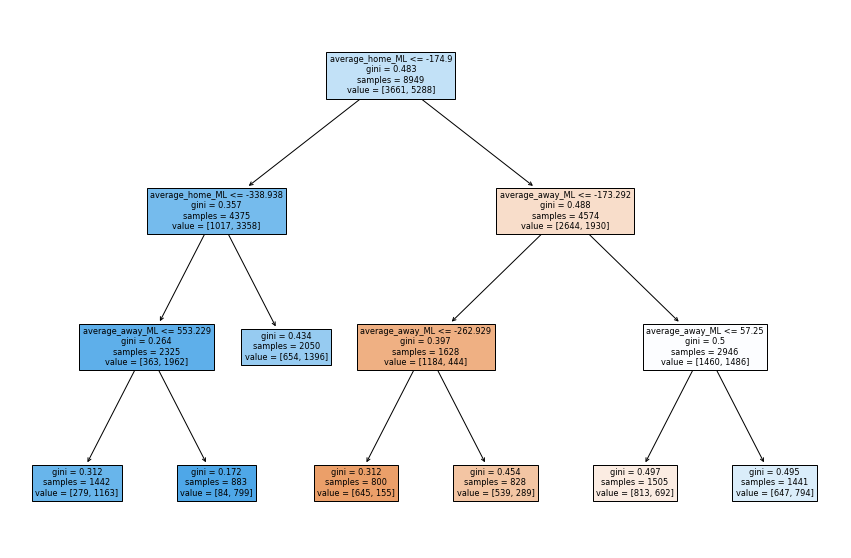

In [60]:
plt.figure(figsize=(15,10))
_ = tree.plot_tree(tuned_baseline_model, 
                   feature_names=X_train.columns,  
                   filled=True)


**Notes**
- Depsite being trained on a wider variety of features, the baseline decision tree only utilizes average home and average away moneylines to classify games
    - Not entirely surprising because the only other features are extracted from each team's immediately previous game (which probably doesn't hold much predictive power).
    
   
    
- This explains why the model performs very similarly to vegas baseline (which always chooses then favorite to win)

- Gini impurity values at leaves are only "good" when classifying heavy favorites 

In [61]:
# Precision, recall, f1 score for training set
baseline_precision_recall_f1_train = pd.DataFrame(precision_recall_fscore_support(y_train, tuned_baseline_model.predict(X_train)), index=['precision','recall','f1','num_class'], 
                                            columns=['away_wins','home_wins'])

baseline_precision_recall_f1_train.loc['prop_class'] = baseline_precision_recall_f1_train.loc['num_class']/len(train_results_df)

baseline_precision_recall_f1_train

,away_wins,home_wins
precision,0.637408,0.713893
recall,0.545479,0.785174
f1,0.587872,0.747839
num_class,3661.000000,5288.000000
prop_class,0.409096,0.590904


In [62]:
# Precision, recall, f1 score for validation set
baseline_precision_recall_f1_val = pd.DataFrame(precision_recall_fscore_support(y_val, tuned_baseline_model.predict(X_val)), index=['precision','recall','f1','num_class'], 
                                            columns=['away_wins','home_wins'])

baseline_precision_recall_f1_val.loc['prop_class'] = baseline_precision_recall_f1_val.loc['num_class']/len(val_results_df)

baseline_precision_recall_f1_val

,away_wins,home_wins
precision,0.622180,0.716519
recall,0.548922,0.773776
f1,0.583260,0.744048
num_class,1206.000000,1777.000000
prop_class,0.404291,0.595709


**Proportion of times model accurately predicted home and away teams to win**

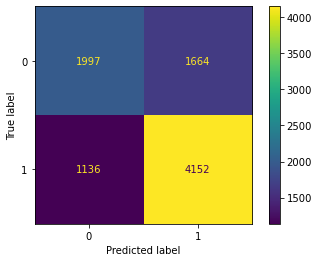

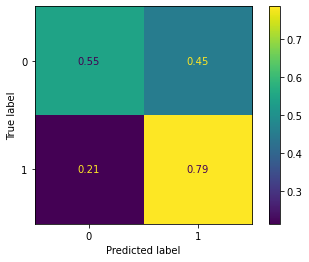

In [63]:
# Confusion Matrix for train set
plot_confusion_matrix(tuned_baseline_model, X_train, y_train)
plt.show()
plot_confusion_matrix(tuned_baseline_model, X_train, y_train,normalize='true')
plt.show()

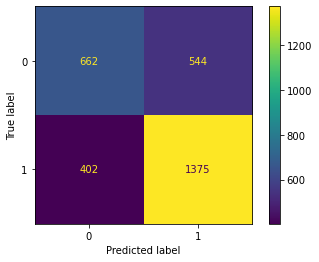

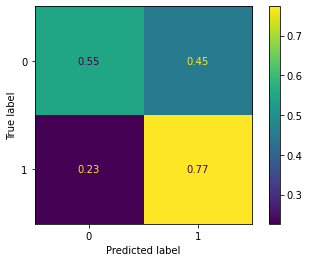

In [64]:
# Confusion Matrix for val set
plot_confusion_matrix(tuned_baseline_model, X_val, y_val,)
plt.show()
plot_confusion_matrix(tuned_baseline_model, X_val, y_val,normalize='true')
plt.show()

**Notes**

- Prop of each class is nearly identical for each dataset 
    - ~60% home win, ~40% away win
    
    
    
- Recall and precision are similar for training and validation results


- Model accurately predicts: (recall)
    - ~78% of actual home wins
    - ~55% of actual away wins
    
    
    
- Model is better at selecting winner when the home team wins, however there are more games in the dataset where the home team wins


**Number of times model accurately predicted home and away underdogs/favorites to win**

In [65]:
def fav_and_underdog_predictions_ML(results_df, result_type, print_results=False):
    
    #filter for home and away favorite wins
    if result_type == 'favorite':
        home_wins_filter = (results_df['win'] == 1) & (results_df['favorite']==1)
        away_wins_filter = (results_df['win'] == 0) & (results_df['favorite']==0)
        
    #filter for home and away underdog wins        
    if result_type == 'underdog':
        home_wins_filter = (results_df['win'] == 1) & (results_df['favorite']==0)
        away_wins_filter = (results_df['win'] == 0) & (results_df['favorite']==1)
        
    #number of times fav/underdog home wins 
    num_home_wins = len(results_df[home_wins_filter])
    
    #number of times away fav/underdog wins    
    num_away_wins = len(results_df[away_wins_filter])
    
    #total number of times the favorite/underdog wins    
    total_wins = num_home_wins + num_away_wins
    
    #filter for all correct predictions 
    correct_preds = results_df['win'] == results_df['pred']
    
    #number of correctly predicted home favorite/underdog wins
    correct_home_preds = len(results_df[correct_preds & home_wins_filter])
    
    #number of correctly predicted away favorite/underdog wins    
    correct_away_preds = len(results_df[correct_preds & away_wins_filter])
    
    #total number of correctly predicted favorite wins        
    total_correct_preds = correct_home_preds + correct_away_preds
    
    
    prop_correct_home = correct_home_preds/num_home_wins
    prop_correct_away = correct_away_preds/num_away_wins
    prop_correct_total = total_correct_preds/total_wins


    home_results = {'correct_pred':correct_home_preds,
                    'true':num_home_wins,
                    'proportion':prop_correct_home
                   }

    away_results = {'correct_pred':correct_away_preds,
                    'true':num_away_wins,
                    'proportion':prop_correct_away
                   }

    total_results = {'correct_pred':total_correct_preds,
                     'true':total_wins,
                     'proportion':prop_correct_total
                    }
    
    # "true" is actual # of times that the index value occurs in dataset (e.g. the number of times the home underdog wins) 
    # "correct_pred" is the number of times you accurately predict that index value (e.g. # of times you accurately predict the home underdog to win)


    return pd.DataFrame([home_results, away_results, total_results], 
                        index=['home_'+result_type+'_wins','away_'+result_type+'_wins','total_'+result_type+'_wins'])






In [66]:
train_favorite_underdog_df = pd.concat([fav_and_underdog_predictions_ML(train_results_df, 'underdog',False), fav_and_underdog_predictions_ML(train_results_df, 'favorite',False)])
print("Train Set: Favorite and Underdog Classification Results")
train_favorite_underdog_df

# "true" is actual # of times that the index value occurs in dataset (e.g. the number of times the home underdog wins in the dataset) 
# "correct_pred" is the number of times you accurately predict that index value (e.g. # of times you accurately predict the home underdog to win)

Train Set: Favorite and Underdog Classification Results


,correct_pred,true,proportion
home_underdog_wins,0,1046,0.000000
away_underdog_wins,121,1785,0.067787
total_underdog_wins,121,2831,0.042741
home_favorite_wins,4152,4242,0.978784
away_favorite_wins,1876,1876,1.000000
total_favorite_wins,6028,6118,0.985289


In [67]:
val_favorite_underdog_df = pd.concat([fav_and_underdog_predictions_ML(val_results_df, 'underdog',False), fav_and_underdog_predictions_ML(val_results_df, 'favorite',False)])
print("Validation Set: Favorite and Underdog Classification Results")
# Number of times model accurately predicted home and away underdogs and favorites to win 
val_favorite_underdog_df

Validation Set: Favorite and Underdog Classification Results


,correct_pred,true,proportion
home_underdog_wins,0,362,0.000000
away_underdog_wins,30,574,0.052265
total_underdog_wins,30,936,0.032051
home_favorite_wins,1375,1415,0.971731
away_favorite_wins,632,632,1.000000
total_favorite_wins,2007,2047,0.980459


In [68]:
# Prop. of model predicting favorite to win in train set
(train_results_df['favorite'] == train_results_df['pred']).sum()/len(train_results_df)

0.9764219465862107

In [69]:
# Prop. of model predicting favorite to win in val set
(val_results_df['favorite'] == val_results_df['pred']).sum()/len(val_results_df)

0.976533690915186

**Notes**
- Model chooses favorite to win ~97.5% of the time (very rarely predicts underdog)
    - likely because model only uses moneylines (favorites) to classify


- Model never predicts home underdog to win, very rarely picks away underdog to win.

- Predicts all away favorite wins most likely because if a team is favorited when away, they are likely a much better team


- Features of classifier aren't strong enough to pick up on underdog wins


## Key Points

- Vegas Baselines (pick favorite to win):
    - train accuracy: 0.683652
    - val accuracy: 0.686222


- The simple baseline model uses a Decision Tree Classifier to predict the outcomes of NBA games (home team wins = 1, home team loses = 0) from each team's previous game advanced stats (e.g. efg%_roll_1, nrtg_roll_1, etc.), point differentials, and average money lines.  


- The base settings for the Decision Tree model overfit the data (training accuracy = 1.0, validation accuracy = 0.59705).  After some rudimentary hyperparameter tuning, the training accuracy dropped to 0.687116 and **validation accuracy increased to 0.6828696**.  On the pure test set (not used to tune the model), which is comprised of the 2021 season, the model's accuracy was 0.65158. 
    - very similar to vegas baselines


- Baseline **only uses moneylines** to predict outcomes of games (despite being fed wider variety of features) which is why...


- Baseline very bad at predicting underdogs to win (i.e. model **almost always picks vegas favorite to win**, because favorites do win 68% of the time)
    - roll_1 features don't contain much predictive power
    
    
    
- Decision Tree diagram shows that the model is only confident when picking heavy favorites to win (shown by bold-colored leaves and relatively small gini impurity values) 
   



**Notes** 
- Need better features to be able to pick up underdog wins

- Including the odds as a feature might sway the model too much. Should look into including an indicator to represent which team is the favorite instead?

- It is relatively easy to identify the favorite in a game (even without vegas odds), so the key to making a good model lies in being able to accurately predict games where the underdog wins or the odds are very close

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**